# Deep Convolutional Generative Adversarial Network using TensorFlow 2

## Introduction

In this notebook, we will implement Deep Convolutional Generative Adversarial Network (DC GAN) using TensorFlow framework on the benchmark Fashion MNIST dataset. To follow along, a basic understanding of Python and Deep Learning is necessary. Besides, it is important to be aware of the theory of the Generative Adversarial Network.

![Image](https://www.researchgate.net/publication/331282441/figure/fig3/AS:729118295478273@1550846756282/Deep-convolutional-generative-adversarial-networks-DCGAN-for-generative-model-of-BF-NSP.png)

[Source](https://www.researchgate.net/figure/Deep-convolutional-generative-adversarial-networks-DCGAN-for-generative-model-of-BF-NSP_fig3_331282441)

## Installation and imports

In [1]:
# Data Handling toolbox
import numpy as np
import matplotlib.pyplot as plt
import glob
import imageio
import os
import time

# Machine Learning Toolbox
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Dropout, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Visualization Purpose
from IPython import display

In [2]:
# Load the data
from tensorflow.keras.datasets import fashion_mnist as dataset
(train_images, train_labels), (_, _) = dataset.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## Data Preprocessing

In [3]:
# reshaping the train images and converting data type to "float32"
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [4]:
# Normalizing the train images
train_images = (train_images - 127.5) / 127.5

In [5]:
# define the constants
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Define the Models

As we know, the Generative Adversarial Network consists of two models - Generator and Discriminator. Generator generates images whereas Discriminator tries to estimate if the generated image is really "generated" or is just a part of the dataset used. Therefore, Discriminator is a binary classifier and Generator is an unsupervised Deep Learning Model. In this example, we demonstrate DC GAN and, hence, we Deep Convolutional Networks for both the models.  

In [7]:
# We use the basic generator model defined by the TensorFlow Documentation [1].
generator = Sequential([
                        # input dense layer, with batch normalization and Leaky ReLU
                        Dense(7*7*256, use_bias=False, input_shape=(100,)),
                        BatchNormalization(),
                        LeakyReLU(alpha=0.35),

                        # Reshaping
                        Reshape((7,7,256)),

                        # Add Conv2D Transpose Layer with Batch Normalization and LeakyReLU
                        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
                        BatchNormalization(),
                        LeakyReLU(alpha=0.3), # default value of 0.3 is used

                        # Add Another Layer with the same composition
                        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
                        BatchNormalization(),
                        LeakyReLU(alpha=0.3),

                        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

In [8]:
# We define the discriminator model
discriminator = Sequential([
                        #First Convolution Layer
                        Conv2D(filters=64,kernel_size=(3,3),padding='same',
                               kernel_initializer='he_normal',
                               activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
                        
                        # Add drop out
                        Dropout(0.4),

                        #Third Convolution Layer
                        Conv2D(filters=128,kernel_size=(3,3),padding='same',
                               kernel_initializer='he_normal',
                               activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
                        
                        #Flattening the output from last conv layer
                        Flatten(),

                        #Using Feed Forward NN as final layers for Classification
                        #Feed Forward Layer 1
                        Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.001)),

                        #Feed Forward Layer 2
                        Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.001)),

                        #Feed Forward Layer 3
                        Dense(32, activation='relu'),

                        #Output Layer
                        Dense(1)
])

## Define the Loss Functions

Since we have two models, we need to define two loss functions - one for generator and one for discriminator. 

The losses defined below are based on the official TensorFlow Documentation.

In [9]:
cross_entropy = BinaryCrossentropy(from_logits=True)

In [10]:
# define the Generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
# define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Define the Optimizers

Like Loss Functions, we need to define two optimizers

In [12]:
# Optimizer for Generator
generator_optimizer = Adam(1e-4)

In [13]:
# Optimizer for Discriminator
discriminator_optimizer = Adam(1e-4)

## Checkpoint

In [14]:
# Set up the checkpoint directory
checkpoint_dir = '/content/chkpt/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training the Deep Convolutional GAN

In [15]:
# define a helper function
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [16]:
# define the parameters and set the seed
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Since we are simultaneously training two models,
    # we use tf.GradientTape() to look out for respective variables of two models
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [18]:
# Let's define the train loop
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

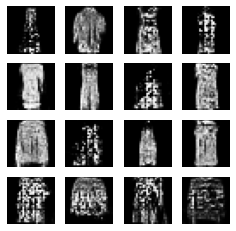

In [20]:
# Let's train
train(train_dataset, EPOCHS)

## Generate the GIF 

Let us generate a GIF to understand the evolution of Fake Images as the Generator gets better in its performance

In [21]:
# The code is based on TensorFlow Official Documentation [1]
# define the GIF file
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  # get the files starting with "image"
  filenames = glob.glob('image*.png')
  # sort the files to visualize the evolution
  filenames = sorted(filenames)
  for filename in filenames:
    # read the image file
    image = imageio.imread(filename)
    # append image file
    writer.append_data(image)
  # get the "image" form
  image = imageio.imread(filename)
  # append the image
  writer.append_data(image)

## References

* [TensorFlow Documentation](https://www.tensorflow.org/tutorials/generative/dcgan)

* [Difference between Upsampling and Conv2DTranspose used in U-Net and GANs](https://youtu.be/fMwti6zFcYY)

* [How to use the UpSampling2D and Conv2DTranspose Layers in Keras](https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/)

* [Understand the loss functions and training of a GAN](https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/)

* [Understand the Gradient Tape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)